In [ ]:
from functions.adjust_cases_functions import prepare_cases 
from functions.general_utils import  get_bool
from models.seird_model import SEIRD

from statsmodels.tsa.arima.model import ARIMA


import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import numpy as np
import os

from global_config import config


poly_run  = 11001
name_dir  = 'bogota'
drop_last_weeks = False

data_dir            = config.get_property('data_dir_covid')
geo_dir             = config.get_property('geo_dir')
data_dir_mnps       = config.get_property('data_dir_col')
results_dir         = config.get_property('results_dir')

agglomerated_folder = os.path.join(data_dir, 'data_stages', 'colombia', 'agglomerated', 'geometry' )
raw_folder          = os.path.join(data_dir, 'data_stages', 'colombia', 'raw', 'cases' )

polygons = pd.read_csv(os.path.join(agglomerated_folder, 'polygons.csv')).set_index('poly_id')
polygons = polygons.loc[poly_run]


data_raw  =  pd.read_csv(os.path.join(raw_folder, 'cases_raw.csv'), dayfirst=True)

data  =  pd.read_csv(os.path.join(agglomerated_folder, 'cases.csv'), parse_dates=['date_time'], dayfirst=True).set_index('poly_id')
data  = data.loc[poly_run].set_index('date_time')
data  = data.resample('D').sum().fillna(0)[['num_cases','num_diseased']]
data  = prepare_cases(data, col='num_cases', cutoff=0)   
data  = prepare_cases(data, col='num_diseased', cutoff=0)


In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15.5, 14.2))

ax[0].plot(data.index.values, data.smoothed_num_cases, color='k', linewidth=2)
ax[0].scatter(data.index.values, data.num_cases, edgecolor='k', facecolor='w')

ax[1].plot(data.index.values, data.smoothed_num_diseased, color='r', linewidth=2)
ax[1].scatter(data.index.values, data.num_diseased, edgecolor='r', facecolor='w')


# ARIMA 

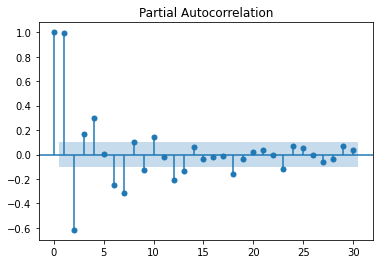

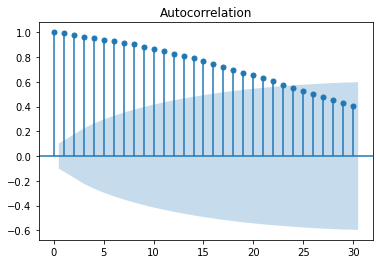

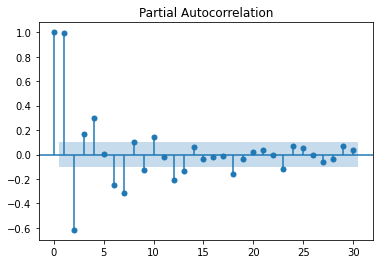

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data.smoothed_num_cases, lags=range(31))

plot_pacf(data.smoothed_num_cases, lags=range(31))

In [9]:
from statsmodels.tsa.stattools import acf, pacf

/Users/chaosdonkey06/conda/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


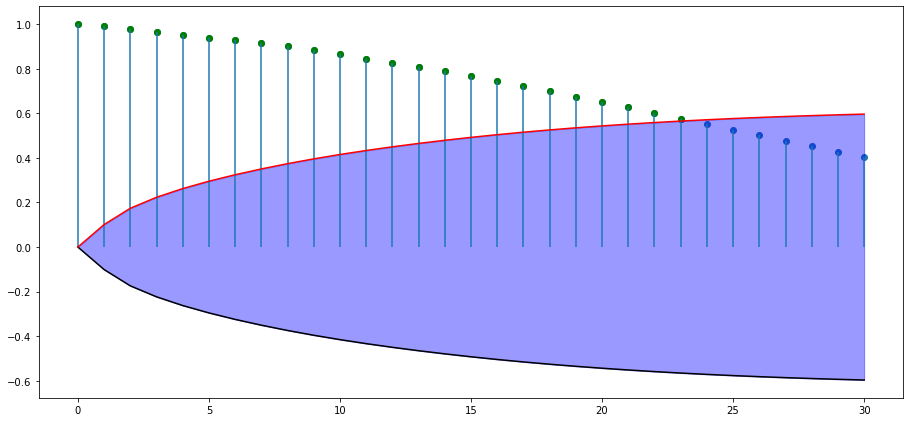

In [74]:


fig, ax = plt.subplots(1,1,figsize=(15.5, 7.2))
ax.scatter(range(31), a[0],)

ax.scatter(np.where(idx_keep)[0], a[0][idx_keep], color='green')

ax.vlines(range(31), [0], a[0] )
ax.fill_between(range(31), a[1][:,0]-a[0], a[1][:,1]-a[0], color='blue', alpha=0.4)

ax.plot(range(31), a[1][:,0]-a[0], color='k')
ax.plot(range(31), a[1][:,1]-a[0], color='red')

In [79]:
list(range(31))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

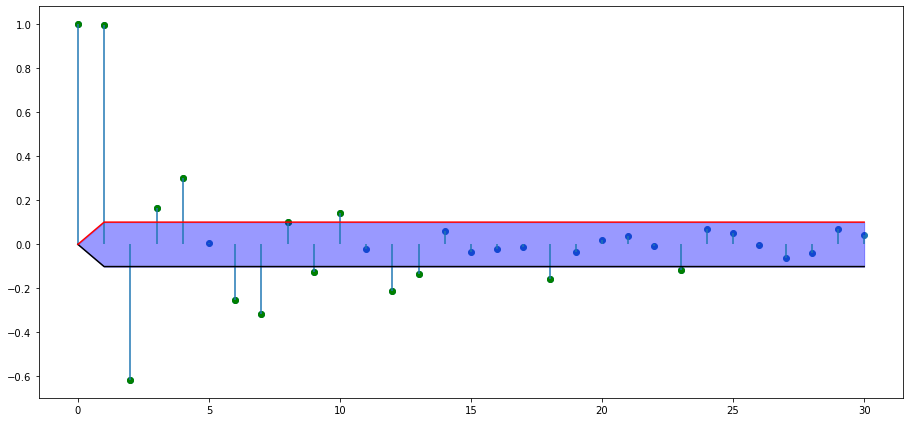

In [71]:
a = pacf(data.smoothed_num_cases, nlags=30, alpha=0.05)
idx_keep = (a[0]<= a[1][:,0]-a[0]) + (a[0]>= a[1][:,1]-a[0])

fig, ax = plt.subplots(1,1,figsize=(15.5, 7.2))
ax.scatter(range(31), a[0],)

ax.scatter(np.where(idx_keep)[0], a[0][idx_keep], color='green')

ax.vlines(range(31), [0], a[0] )
ax.fill_between(range(31), a[1][:,0]-a[0], a[1][:,1]-a[0], color='blue', alpha=0.4)

ax.plot(range(31), a[1][:,0]-a[0], color='k')
ax.plot(range(31), a[1][:,1]-a[0], color='red')

In [77]:
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

class ARIMA_model(object):
    
    @classmethod
    def fit_arima(cls, data, order):

        model = ARIMA(data, order=order).fit()
        aic   = model.aic
        return (model, aic)
    
    @classmethod
    def optimize_arima(cls, data, d_values=[1]):
        
        
        acf_d    = acf(data, nlags=30, alpha=0.05)
        p_values = np.where((acf_d[0]<= acf_d[1][:,0]-acf_d[0]) + (acf_d[0]>= acf_d[1][:,1]-acf_d[0]))

        pacf_d   = pacf(data, nlags=30, alpha=0.05)
        q_values = np.where((pacf_d[0]<= pacf_d[1][:,0]-pacf_d[0]) + (pacf_d[0]>= pacf_d[1][:,1]-pacf_d[0]))

        best_aic   = 0
        best_model = None
        best_cfg   = None
        
        for p in tqdm(p_values):
            for d in d_values:
                for q in q_values:
                    order = (p,d,q)
                    model, aic = cls.fit_arima(data, order=order)

                    if aic < best_aic:
                        best_aic, best_cfg = aic, order
                        best_model = model
    
        
        return (best_model, best_cfg, best_aic)
    
    def forecast_arima(cls, data=None, T_future=28, quantiles=[50, 80, 95]):


        if data is not None:
            df = data
            df[df==0]+=1
            loggeded_df = np.log(df)
            (best_model, best_cfg, best_aic) = cls.optimize_arima(loggeded_df)
            
            PredictionResultsWrapper = best_model.get_forecast(steps=T_future, dynamic=True)
            Forecast = np.exp(PredictionResultsWrapper.predicted_mean)
            
            
            ci_95    = np.exp(PredictionResultsWrapper.conf_int(alpha=1.))
            ci_66    = np.exp(PredictionResultsWrapper.conf_int(alpha=.33))
            ci_33    = np.exp(PredictionResultsWrapper.conf_int(alpha=.66))
            
        return (Forecast, ci_95, ci_66, ci_33)

In [78]:
arima_model =  ARIMA_model()

(Forecast, ci_95, ci_66, ci_33)  = arima_model.forecast_arima(data=data.smoothed_num_cases)

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: Invalid AR order. Appears to be a boolean list (since it contains a 0 element and/or multiple elements) but also contains elements greater than 1 like a list of lag orders.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

timeseries_complete = data.smoothed_num_cases.copy()
timeseries_complete[timeseries_complete==0]+=1
logged_timeseries_complete = np.log(timeseries_complete).diff().dropna()

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

plot_acf(logged_timeseries_complete, ax=ax1, lags = range(0,31))
ax1.set_title('Autocorrelation')
ax1.set_xlabel(r"Lag")
ax1.set_ylabel(r"Correlation")

plot_pacf(logged_timeseries_complete, ax=ax2, lags = range(0,31))
ax2.set_title('Partial autocorrelation')
ax2.set_xlabel(r"Lag")
ax2.set_ylabel(r"Correlation")

plt.show()

In [ ]:
# evaluate parameters
p_values = [0,1,3,6,7,8,16,23,24,25,27] # Only selecting values above significance threshold to save time
d_values = [1]
q_values = [0,1,3,5,8,14,21,25]


In [ ]:

# evaluate combinations of p, d and q values for an ARIMA model
def best_arima_model(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_aic, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order=order).fit()
                    aic = model.aic
                    if aic < best_aic:
                        best_aic, best_cfg = aic, order
                    #print('ARIMA%s AIC=%.3f' % (order,aic))
                except:
                    continue
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_aic))
    return best_cfg


In [ ]:
#Arima does the differencing, so I only need the logged timeseries
log_train_undifferenced = data.smoothed_num_cases.values.copy()
log_train_undifferenced[log_train_undifferenced==0]+=1
log_train_undifferenced = np.log(log_train_undifferenced)

In [ ]:
num_forecasts = 30 
p, d, q = optimal_order_train
df = data.smoothed_num_cases
df[df==0]+=1

loggeded_df = np.log(df)
arima = ARIMA(loggeded_df, order=(p,d,q)).fit()
PredictionResultsWrapper = arima.get_forecast(steps=num_forecasts, dynamic=True)

In [ ]:
Forecast = np.exp(PredictionResultsWrapper.predicted_mean)
ci_95 = np.exp(PredictionResultsWrapper.conf_int(alpha=.05))
ci_66 = np.exp(PredictionResultsWrapper.conf_int(alpha=.33))
ci_33 = np.exp(PredictionResultsWrapper.conf_int(alpha=.66))

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15.5, 14.2))

ax[0].plot(data.index.values, data.smoothed_num_cases, color='k', linewidth=2)
ax[0].scatter(data.index.values, data.num_cases, edgecolor='k', facecolor='w')
ax[0].plot(Forecast.index.values, Forecast.values, color='salmon')
ax[0].fill_between(ci_95.index.values, ci_95["lower smoothed_num_cases"], ci_95["upper smoothed_num_cases"],
                   alpha=0.5, color='salmon')
ax[0].fill_between(ci_95.index.values, ci_66["lower smoothed_num_cases"], ci_66["upper smoothed_num_cases"],
                   alpha=0.5, color='salmon')
ax[0].fill_between(ci_95.index.values, ci_33["lower smoothed_num_cases"], ci_33["upper smoothed_num_cases"],
                   alpha=0.5, color='salmon')


ax[1].plot(data.index.values, data.smoothed_num_diseased, color='r', linewidth=2)
ax[1].scatter(data.index.values, data.num_diseased, edgecolor='r', facecolor='w')

In [ ]:
!pip uninstall torch; Y

In [ ]:
import argparse
from os.path import exists
from urllib.request import urlopen

import numpy as np
import torch

import pyro
from pyro.contrib.timeseries import IndependentMaternGP, LinearlyCoupledMaternGP


# download dataset from UCI archive
def download_data():
    if not exists("eeg.dat"):
        url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff"
        with open("eeg.dat", "wb") as f:
            f.write(urlopen(url).read())
